<h1><center>Silkroad 2 <br>
Analyzing the illegal drugsmarket hiding behind the darknet<center><h1>

<img src='http://i.dailymail.co.uk/i/pix/2013/10/03/article-2442336-187DD1FC00000578-93_634x472.jpg'/ width=500px length=500px>

Dataset used from https://www.gwern.net/DNM%20archives

## 1: Imports and setting up the file-directories

In [1]:
# Imports
import os 
from bs4 import BeautifulSoup
import re
from collections import defaultdict
import operator
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import chain
import pandas as pd

In [2]:
# Find all the directories to parse files in.
first_dir= '2014-08-30-categories'
final_dir= []
all_items= []

for filename in os.listdir(first_dir):
    if filename.startswith('.') is not True:   # Skip the .DS Store file
        if filename.startswith('drugs'):
            naam=str(filename)
            final_dir.append(first_dir+'/'+naam) # All drug related directories

for files in final_dir:
    for filename in os.listdir(files):
        all_items.append(files+'/'+filename)

## 2: Function that extracts the shipping data

In [3]:
shipping = defaultdict(list)     # contains the shipping from and to

def find_shipping_information(filepath):
    
    ''' This function takes a file(path)
    as parameter and returns the corresponding
    shipping data. The keys in the dictionary 
    depict which country is shipped from, where
    the values are the possible shipping countries.
    '''
    
    soup = BeautifulSoup(open(filepath),"lxml")                # Open file with soup and initialize lists
    shipping_tags=[]
    shipping_tags_no_whitespace= []
    
    try:
        find_shipping= soup.findAll('div', {'class' :'shipping'})  # Find all shipping divs and extract text
        for x in find_shipping:
             shipping_tags.append(x.text)

        for y in shipping_tags:                                    # Remove unneccesary whitespaces
            shipping_tags_no_whitespace.append(" ".join(y.split()))

        for z in shipping_tags_no_whitespace:           # Find the shipping country, and the countries shipped to
            find_shipping_from= re.findall(r'(?<=ships from:)(.*)(?=ships to:)',z)
            find_shipping_to= re.findall("ships to: (.*)", z)
            for x in find_shipping_from:
                for y in find_shipping_to:            
                    shipping[x].append(y)     

    except:
        pass

In [4]:
for files in all_items:                # Run the function over all files in the directories
    find_shipping_information(files)
    
shipped_from_countries= shipping.keys()   # Create a dictionary including number of advertisements per country 
count_advertisements_per_country= {}

for country in shipped_from_countries:
    number= len(shipping.get(country))
    count_advertisements_per_country[country]=number

sorted_by_advertisements = sorted(count_advertisements_per_country.items(), key=operator.itemgetter(1),reverse=True)

## 3: Plotting the number of drug advertisements per export country on Silkroad 2

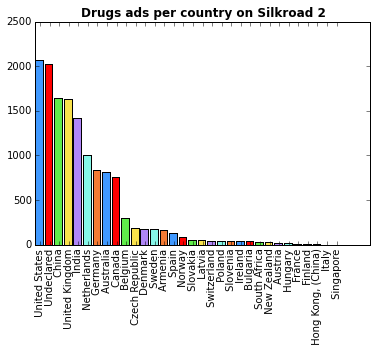

In [5]:
labels, values = zip(*sorted_by_advertisements)
indexes = np.arange(len(labels))
width = 1
colors = ['#4099FF', 'r', '#60EC4A', '#F9E24C', '#B086F7', '#86F7E8', '#F47A33']
plt.bar(indexes, values, color=colors)
plt.xticks(indexes + width * 0.5, labels,rotation=90)
plt.title('Drugs ads per country on Silkroad 2', weight='bold')
plt.show()

## 4. Function that finds all vendors and their corresponding country

In [6]:
vendors = defaultdict(list)     # contains the vendors and their presumable home country

def find_vendors_with_country(filename):
    soup = BeautifulSoup(open(filename),"lxml")                # Open file with soup and initialize lists and dicts
    find_item= soup.findAll('div', {'class' :'item'})
    for x in find_item:
        vendor=[]
        shipping=[]
        find_vendor= x.findAll('div', {'class' :'vendor'})  # Find vendor
        for vend in find_vendor:
            vendor_list= vend.text.split()[:-1]         # remove 'sold by' and 'rating', only keep usernames
            target_ibdex= vendor_list.index('by')
            vendor.append(vendor_list[target_ibdex+1:])

        find_shipping= x.findAll('div', {'class' :'shipping'})  # Find all shipping divs and extract text
        for ship in find_shipping:
            ship_list=[]
            ship2=ship.text
            ship3= " ".join(ship2.split())
            find_shipping_from= re.findall(r'(?<=ships from:)(.*)(?=ships to:)',ship3)
            ship_list.append(find_shipping_from)
            shipping_from= list(chain.from_iterable(ship_list))
            shipping.append(shipping_from)

        vendor= list(chain.from_iterable(vendor))
        shipping= list(chain.from_iterable(shipping))
        for key, value in zip(vendor, shipping):
            vendors[key].append(value)

In [7]:
for files in all_items:                # Run the function over all files in the directories
    find_vendors_with_country(files)

In [8]:
pd.DataFrame(vendors.items(), columns=['Vendor', 'Country']).head()

,Vendor,Country
0,Bisto,"[ United Kingdom , United Kingdom , United K..."
1,-ThePakistani-,"[ Undeclared , Undeclared , Undeclared , Un..."
2,elpico,"[ Netherlands , Netherlands , Netherlands , ..."
3,KeithLemon,"[ United Kingdom , United Kingdom , United K..."
4,ThreeKings,"[ Undeclared , Undeclared , Poland , Poland..."


In [9]:
US= ' United States '           # Calculate the number of unique sellers for the top 5 countries
NL= ' Netherlands '
CH= ' China '
UK= ' United Kingdom '
IN= ' India '
number_of_sellers_by_country= {US:0, NL:0, CH:0, UK:0, IN:0}

for k,v in vendors.iteritems():
    if US in v:
        number_of_sellers_by_country[US]+= 1
    if NL in v:
        number_of_sellers_by_country[NL]+= 1
    if CH in v:
        number_of_sellers_by_country[CH]+= 1
    if UK in v:
        number_of_sellers_by_country[UK]+= 1
    if IN in v:
        number_of_sellers_by_country[IN]+= 1

sorted_by_sellers = sorted(number_of_sellers_by_country.items(), key=operator.itemgetter(1),reverse=True)

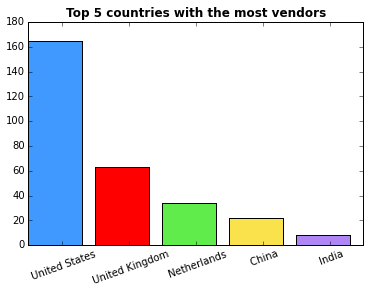

In [10]:
labels, values = zip(*sorted_by_sellers)
indexes = np.arange(len(labels))
width = 1
colors = ['#4099FF', 'r', '#60EC4A', '#F9E24C', '#B086F7', '#86F7E8', '#F47A33']
plt.bar(indexes, values, color=colors)
plt.xticks(indexes + width * 0.5, labels,rotation=20)
plt.title('Top 5 countries with the most vendors', weight='bold')
plt.show()

## 5. Most expensive product

In [11]:
prices_by_title = defaultdict(list)     # contains product-titles and their price

def find_most_expensive_product(filename):
    soup = BeautifulSoup(open(filename),"lxml")             # Open file with soup and initialize lists and dicts
    find_item= soup.findAll('div', {'class' :'item'})
    
    price= []
    title=[]
    for x in find_item:
        find_price= x.findAll('div', {'class' :'price'})  # Find price
        find_title= x.findAll('div', {'class' :'item_title'})  # Find title
        for x in find_price:
            price.append(x.text)
        for y in find_title:
            title.append(y.text)       
       
        for t, p in zip(title, price):
            prices_by_title[t]= (p)

In [12]:
for files in all_items:                # Run the function over all files in the directories
    find_most_expensive_product(files)

In [13]:
for k,v in prices_by_title.iteritems():
    prices_by_title[k] = v.encode('ascii','ignore')   # ASCII does not support the Bitcoin sign, so ignore.
    
price_df= pd.DataFrame(prices_by_title.items(), columns=['Advertisement Title', 'Price in Bitcoins']) # Create df
price_df2= price_df.sort_values('Price in Bitcoins',ascending=False)
price_df2.head()

,Advertisement Title,Price in Bitcoins
4583,1kg Highest Purity Cocaine - Direct From Colombia,99.009906
127,100 White Domino's 220MG MDMA,931696658271443200.000000
6741,1500 grams of pure butylone (bk-MBDB),9.978070
384,100 doses LSD Strong 150 ug,9.962634
6858,1000 x LSD Blotter | 120ug Pure White LSD Xtal...,9.873641


In [ ]:
# Converting this notebook to a slideshow
!jupyter nbconvert --post serve --to slides --reveal-prefix "http://maartenmarx.nl/reveal.js" DSProjectSlides.ipynb